In [233]:
from IPython.display import clear_output
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import re
import dropbox
import sys
import pandas as pd
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import cv2
import logging
import datetime
import glob
import json
import scipy
import matplotlib as mpl

from subprocess import call
from tifffile import imwrite
from tqdm import tqdm
from pathlib import Path
from amftrack.util.dbx import (
    upload_folder,
    download,
    read_saved_dropbox_state,
    save_dropbox_state,
    load_dbx,
    get_dropbox_folders_prince,
    get_dropbox_video_folders,
    download_video_folders_drop,
    download_analysis_folders_drop,
)
from amftrack.pipeline.launching.run import (
    run_transfer,
)
from amftrack.pipeline.launching.run_super import run_parallel_transfer
from amftrack.pipeline.launching.run_super import run_parallel_flows
from amftrack.pipeline.functions.transport_processing.high_mag_videos.plot_data import (
    plot_summary,
    save_raw_data,
)
from amftrack.pipeline.functions.transport_processing.high_mag_videos.high_mag_analysis import (
    HighmagDataset,
    VideoDataset,
    EdgeDataset,
    index_videos_dropbox_new,
    analysis_run,
)
from amftrack.pipeline.functions.transport_processing.high_mag_videos.kymo_class import (
    KymoVideoAnalysis,
    KymoEdgeAnalysis,
)
from amftrack.util.dbx import (upload
)
%load_ext autoreload
%autoreload 2
from amftrack.pipeline.launching.run_super import (
    run_launcher,
    directory_scratch,
    directory_project,
    directory_project,
    run_parallel_stitch,
    run_parallel_transfer,
)
import os
from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Experiment,
    save_graphs,
    load_graphs,
    Edge,
    Node,

)
from amftrack.pipeline.functions.image_processing.experiment_util import (
    get_random_edge,
    distance_point_edge,
    plot_edge,
    plot_edge_cropped,
    find_nearest_edge,
    get_edge_from_node_labels,
    plot_full_image_with_features,
    get_all_edges,
    get_all_nodes,
    find_neighboring_edges,
    reconstruct_image,
    reconstruct_skeletton_from_edges,
    reconstruct_skeletton_unicolor,
    reconstruct_image_from_general,
    plot_full,
    plot_edge_color_value,
)
from amftrack.transport.align_video_network import identify_nodes
logging.basicConfig(stream=sys.stdout, level=logging.debug)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [234]:
plate_id = "310_20230830"
plate_id_video = "20230906_Plate310"

In [235]:
analysis_folder = "/projects/0/einf914/analysis_videos/"
analysis_folder = f"{analysis_folder}{plate_id_video}/"

img_infos = glob.glob(f"{analysis_folder}/**/video_data.json", recursive=True)
vid_anls_frame = pd.DataFrame()
add_infos = []
for address in img_infos:
    add_infos.append(pd.read_json(address, orient="index").T)
vid_anls_frame = pd.concat([vid_anls_frame] + add_infos, ignore_index=True)

vid_anls_frame = vid_anls_frame.sort_values("unique_id").reset_index(drop=True)
vid_anls_frame_select = vid_anls_frame.loc[vid_anls_frame["plate_id"] == plate_id_video]

In [236]:
vid_anls_frame_select["record_time"]


0       10:19:29
1       10:19:29
2       10:20:01
3       10:20:01
4       10:20:36
         ...    
119     11:42:12
120     11:44:25
121     11:44:51
122     11:55:13
123     11:55:31
Name: record_time, Length: 124, dtype: object

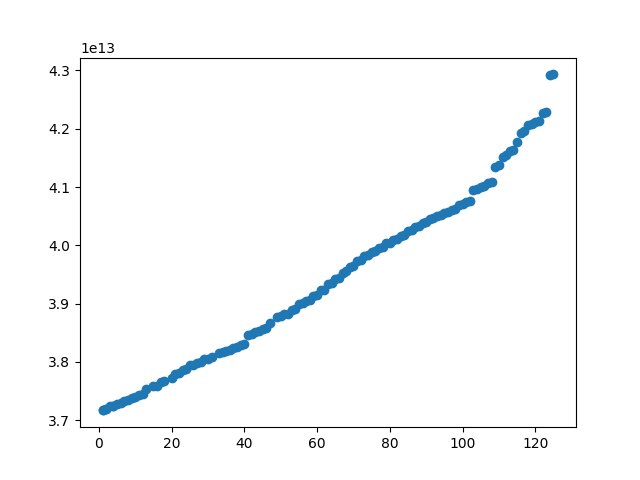

In [237]:
mpl.rcParams["figure.dpi"] = 100

fig, ax = plt.subplots()
vid_anls_frame_select["timedelta"] = pd.to_timedelta(
    vid_anls_frame_select["record_time"]
)

ax.scatter(vid_anls_frame_select["video_int"], vid_anls_frame_select["timedelta"])

In [238]:
plates = [plate_id]

In [9]:
# directory_targ = os.path.join(directory_scratch, "stitch_temp2") + "/"
directory_targ = directory_project

update_plate_info(directory_targ, local=True)
all_folders = get_current_folders(directory_targ, local=True)

analysed:   0%|          | 0/940 [00:00<?, ?it/s]

In [ ]:
folders

In [12]:
folders = all_folders.loc[all_folders["unique_id"] == plates[0]]
folders = folders.loc[folders["/Analysis/nx_graph_pruned_labeled.p"] == True]

In [240]:
folders = folders.sort_values(by="datetime")

exp = Experiment(directory_targ)
i = 77
exp.load(folders.iloc[i : i + 2], suffix="_width")
for t in range(exp.ts):
    exp.load_tile_information(t)

/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2023-09-06 09:51:00
2023-09-06 12:20:00


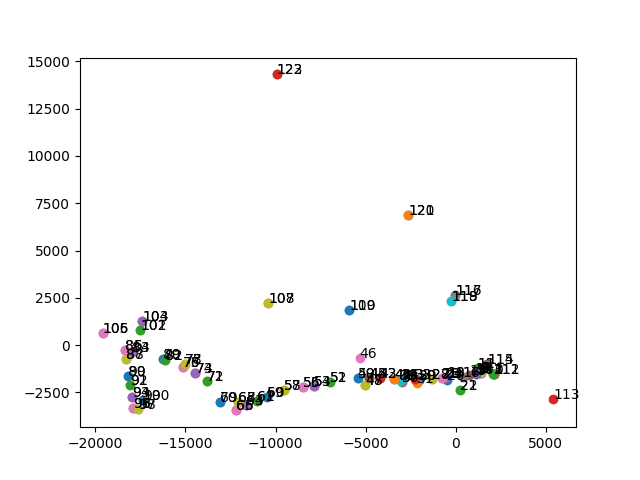

In [241]:
positions = np.array(vid_anls_frame_select[["ypos", "xpos"]]) * 1000 / 1.725
fig, ax = plt.subplots()
for i, pos in enumerate(positions):
    ax.text(int(pos[1]), -int(pos[0]), str(i))
    ax.scatter(int(pos[1]), -int(pos[0]))

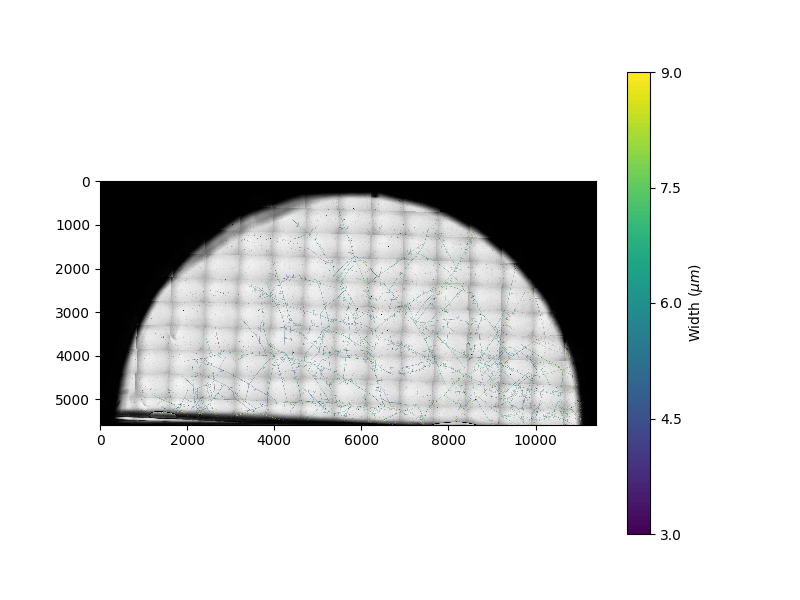

Text(value='', description='Point name:', placeholder='Type point name here')

In [242]:
cid, dicopoint = identify_nodes(exp, 0)

In [308]:
del dicopoint["120"]

In [304]:
dicopoint

{'93': Node(9283),
 '122': Node(3492),
 '120': Node(7622),
 '41': Node(10874),
 '45': Node(10568),
 '57': Node(10609),
 '77': Node(8908),
 '81': Node(8588)}

In [288]:
keys

['93', '122', '120', '7', '41']

In [309]:
keys = list(dicopoint.keys())
posnodes = [dicopoint[key].pos(0).tolist() for key in keys]
posvideoslines = [
    vid_anls_frame_select.loc[vid_anls_frame_select["video_int"] == int(key)]
    for key in keys
]
posvideos = [
    [
        posvideosline["ypos"].astype(float).iloc[0] * 1000 / 1.725,
        posvideosline["xpos"].astype(float).iloc[0] * 1000 / 1.725,
    ]
    for posvideosline in posvideoslines
]

In [310]:
from amftrack.util.image_analysis import find_transformation, find_similarity

transform = find_similarity(posvideos, posnodes)

[1.1267812822523076, 1.1263450258240784, 1.1301987745810411, 1.1370716040790714, 1.123366269306531, 1.1307985543450634, 1.119330845481765, 1.1234349211988786, 1.1244870903585098, 1.114313093839265, 1.1224498560755556, 1.1237172396932404, 1.1245016456835795, 1.125407168222947, 1.127212208845658]
Similarity ratio: 1.1245016456835795
Similarity is a positive similarity
Rotation: [[ 0.99317548  0.1166296 ]
 [-0.1166296   0.99317548]]
Translation: [23971.71680718 31228.09119211]


similarity_ratio should be 1.128

In [311]:
posvideos_new = [transform(pos) for pos in posvideos]
posvideos_new, posnodes

([array([23965.5323914 , 10746.31049137]),
  array([25517.67043419, 27160.8711444 ]),
  array([25278.26305867, 25619.61775451]),
  array([25363.34879268, 21475.84316509]),
  array([23272.63130545, 14185.63875173]),
  array([22666.5540176, 13009.7186929])],
 [[23946, 10716],
  [25531, 27161],
  [25291, 25611],
  [25319, 21504],
  [23277, 14200],
  [22700, 13006]])

In [312]:
positions = np.array(vid_anls_frame_select[["ypos", "xpos"]]) * 1000 / 1.725
positions_list = positions.tolist()
posvideos_new_list = [transform(pos) for pos in positions_list]

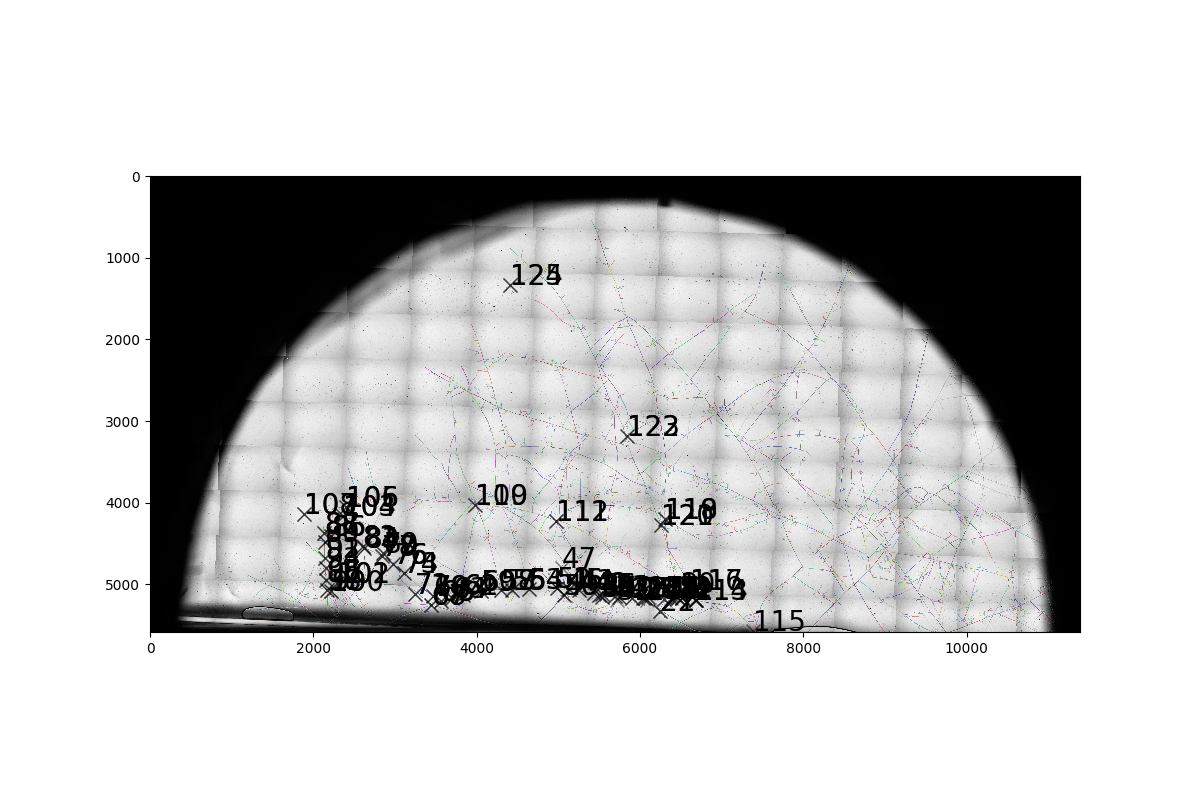

<AxesSubplot:>

In [313]:
t = 0
vmax = 9
vmin = 3
region = None
nodes = get_all_nodes(exp, t)
edges = get_all_edges(exp, t)

downsizing = 5

plot_full_video(
    exp,
    t,
    downsizing=downsizing,
    points=posvideos_new_list,
    video_num=vid_anls_frame_select["video_int"],
    edges=edges,
    dilation=5,
)

In [314]:
img_infos = glob.glob(f"{analysis_folder}/**/video_data.json", recursive=True)
for address in img_infos:
    add_info = pd.read_json(address, orient="index").T
    if add_info["plate_id"].iloc[0] == plate_id_video:
        positions = np.array(add_info[["ypos", "xpos"]]) * 1000 / 1.725
        positions_list = positions.tolist()
        posvideos_new_list = [transform(pos) for pos in positions_list]
        add_info["xpos_network"] = posvideos_new_list[0][0]
        add_info["ypos_network"] = posvideos_new_list[0][1]
        add_info.to_json(address)
        # break

In [315]:
img_infos = glob.glob(f"{analysis_folder}/**/video_data.json", recursive=True)
vid_anls_frame = pd.DataFrame()
for address in img_infos:
    add_info = pd.read_json(address, orient="index").T
    if add_info["plate_id"].iloc[0] == plate_id_video:
        original_path = add_info["tot_path_drop"].iloc[0]

        # Replace the specific substring in the target path
        target_path = original_path.replace(
            f"/{plate_id_video}", f"/Analysis/{plate_id_video}"
        )
        target = "/" + target_path + "/video_data_network.json"
        source = address
        upload(
            source,
            target,
            chunk_size=256 * 1024 * 1024,
        )
        print(target)
    # break

2023-12-15 19:12:30,638-[INFO]- dropbox:390 -> Refreshing access token.
2023-12-15 19:12:30,903-[INFO]- dropbox:474 -> Request to files/upload
/DATA/CocoTransport/Analysis/20230906_Plate310/068/Img/video_data_network.json
2023-12-15 19:12:31,885-[INFO]- dropbox:390 -> Refreshing access token.
2023-12-15 19:12:32,115-[INFO]- dropbox:474 -> Request to files/upload
/DATA/CocoTransport/Analysis/20230906_Plate310/018/Img/video_data_network.json
2023-12-15 19:12:33,186-[INFO]- dropbox:390 -> Refreshing access token.
2023-12-15 19:12:33,389-[INFO]- dropbox:474 -> Request to files/upload
/DATA/CocoTransport/Analysis/20230906_Plate310/056/Img/video_data_network.json
2023-12-15 19:12:34,328-[INFO]- dropbox:390 -> Refreshing access token.
2023-12-15 19:12:34,528-[INFO]- dropbox:474 -> Request to files/upload
/DATA/CocoTransport/Analysis/20230906_Plate310/098/Img/video_data_network.json
2023-12-15 19:12:35,453-[INFO]- dropbox:390 -> Refreshing access token.
2023-12-15 19:12:35,661-[INFO]- dropbox:

In [316]:
t = 0
im, skel_im = make_full_image(
    exp, t, downsizing=5, dilation=5, edges=get_all_edges(exp, t)
)

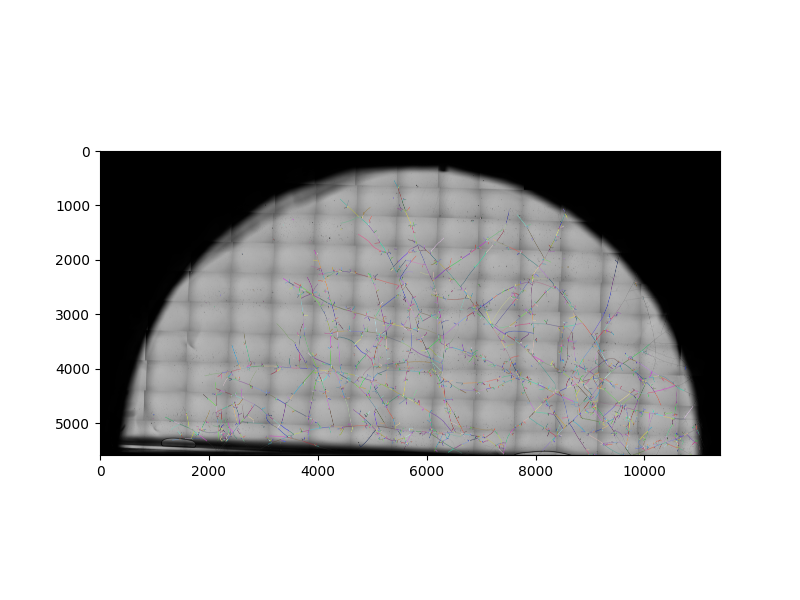

In [317]:
im_rgba = np.stack([im, im, im, np.ones(im.shape, dtype=im.dtype) * 255], axis=-1)
white_mask = np.all(skel_im[:, :, :3] == 255, axis=-1)
skel_im[white_mask, 3] = 0  # setting alpha to 0 where it's white
# Convert numpy arrays to PIL images
im_pil = Image.fromarray(im_rgba.astype(np.uint8))
skel_im_pil = Image.fromarray(skel_im.astype(np.uint8))


# Overlay the images
combined = Image.alpha_composite(im_pil, skel_im_pil)
combined.save(os.path.join(analysis_folder, "network_overlay.png"))
im_pil.save(os.path.join(analysis_folder, "stitched.png"))

fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(combined)

In [318]:
source = os.path.join(analysis_folder, "network_overlay.png")
original_path = vid_anls_frame_select["tot_path_drop"].iloc[0]
new_path = os.path.dirname(os.path.dirname(original_path))
new_path = "/" + new_path
target = new_path + "/network_overlay.png"
target = target.replace(f"/{plate_id_video}", f"/Analysis/{plate_id_video}")

upload(
    source,
    target,
    chunk_size=256 * 1024 * 1024,
)
source = os.path.join(analysis_folder, "stitched.png")

target = new_path + "/stitched.png"
target = target.replace(f"/{plate_id_video}", f"/Analysis/{plate_id_video}")

upload(
    source,
    target,
    chunk_size=256 * 1024 * 1024,
)

2023-12-15 19:16:35,909-[INFO]- dropbox:390 -> Refreshing access token.
2023-12-15 19:16:36,116-[INFO]- dropbox:474 -> Request to files/upload
2023-12-15 19:16:38,716-[INFO]- dropbox:390 -> Refreshing access token.
2023-12-15 19:16:38,908-[INFO]- dropbox:474 -> Request to files/upload


In [43]:
def plot_full_video(
    exp: Experiment,
    t: int,
    region=None,
    edges: List[Edge] = [],
    points: List[coord_int] = [],
    video_num: List[int] = [],
    segments: List[List[coord_int]] = [],
    nodes: List[Node] = [],
    downsizing=5,
    dilation=1,
    save_path="",
    prettify=False,
    with_point_label=False,
    figsize=(12, 8),
    dpi=None,
    node_size=5,
) -> None:
    """
    This is the general purpose function to plot the full image or a region `region` of the image at
    any given timestep t. The region being specified in the GENERAL coordinates.
    The image can be downsized by a chosen factor `downsized` with additionnal features such as: edges, nodes, points, segments.
    The coordinates for all the objects are provided in the GENERAL referential.

    :param region: choosen region in the full image, such as [[100, 100], [2000,2000]], if None the full image is shown
    :param edges: list of edges to plot, it is the pixel list that is plotted, not a straight line
    :param nodes: list of nodes to plot (only nodes in the `region` will be shown)
    :param points: points such as [123, 234] to plot with a red cross on the image
    :param segments: plot lines between two points that are provided
    :param downsizing: factor by which we reduce the image resolution (5 -> image 25 times lighter)
    :param dilation: only for edges: thickness of the edges (dilation applied to the pixel list)
    :param save_path: full path to the location where the plot will be saved
    :param prettify: if True, the image will be enhanced by smoothing the intersections between images
    :param with_point_label: if True, the index of the point is ploted on top of it

    NB: the full region of a full image is typically [[0, 0], [26000, 52000]]
    NB: the interesting region of a full image is typically [[12000, 15000], [26000, 35000]]
    NB: the colors are chosen randomly for edges
    NB: giving a smaller region greatly increase computation time
    """

    # TODO(FK): fetch image size from experiment object here, and use it in reconstruct image
    # TODO(FK): colors for edges are not consistent
    # NB: possible other parameters that could be added: alpha between layers, colors for object, figure_size
    DIM_X, DIM_Y = get_dimX_dimY(exp)

    if region == None:
        # Full image
        image_coodinates = exp.image_coordinates[t]
        region = get_bounding_box(image_coodinates)
        region[1][0] += DIM_X  # TODO(FK): Shouldn't be hardcoded
        region[1][1] += DIM_Y

    # 1/ Image layer
    im, f = reconstruct_image_from_general(
        exp,
        t,
        downsizing=downsizing,
        region=region,
        prettify=prettify,
        white_background=False,  # TODO(FK): add image dimention here dimx = ..
    )
    f_int = lambda c: f(c).astype(int)
    new_region = [
        f_int(region[0]),
        f_int(region[1]),
    ]  # should be [[0, 0], [d_x/downsized, d_y/downsized]]

    # 2/ Edges layer
    skel_im, _ = reconstruct_skeletton(
        [edge.pixel_list(t) for edge in edges],
        region=region,
        color_seeds=[(edge.begin.label + edge.end.label) % 255 for edge in edges],
        downsizing=downsizing,
        dilation=dilation,
    )

    # 3/ Fusing layers
    fig = plt.figure(
        figsize=figsize
    )  # width: 30 cm height: 20 cm # TODO(FK): change dpi
    ax = fig.add_subplot(111)
    ax.imshow(im, cmap="gray", interpolation="none")
    ax.imshow(skel_im, alpha=0.5, interpolation="none")

    # 3/ Plotting the Nodes
    size = node_size
    for node in nodes:
        c = f(list(node.pos(t)))
        color = make_random_color(node.label)[:3]
        reciprocal_color = 255 - color
        color = tuple(color / 255)
        reciprocal_color = tuple(reciprocal_color / 255)
        bbox_props = dict(boxstyle="circle", fc=color, edgecolor="none")
        if is_in_bounding_box(c, new_region):
            node_text = ax.text(
                c[1],
                c[0],
                str(node.label),
                ha="center",
                va="center",
                bbox=bbox_props,
                font=fpath,
                fontdict={"color": reciprocal_color},
                size=size,
                # alpha = 0.5
            )
    # 4/ Plotting coordinates
    points = [f(c) for c in points]
    for i, c in enumerate(points):
        if is_in_bounding_box(c, new_region):
            color = make_random_color(video_num[i])[:3]
            color = tuple(color / 255)
            plt.text(c[1], c[0], video_num[i], color="black", fontsize=20, alpha=1)
            plt.plot(c[1], c[0], marker="x", color="black", markersize=10, alpha=0.5)

            if with_point_label:
                plt.text(c[1], c[0], f"{i}")

    # 5/ Plotting segments
    segments = [[f(segment[0]), f(segment[1])] for segment in segments]
    for s in segments:
        plt.plot(
            [s[0][1], s[1][1]],  # x1, x2
            [s[0][0], s[1][0]],  # y1, y2
            color="white",
            linewidth=2,
        )

    if save_path:
        plt.savefig(save_path, dpi=dpi)
    else:
        plt.show()
    return ax

In [42]:
from amftrack.pipeline.functions.image_processing.experiment_util import *
from PIL import Image


def make_full_image(
    exp: Experiment,
    t: int,
    region=None,
    edges: List[Edge] = [],
    points: List[coord_int] = [],
    video_num: List[int] = [],
    segments: List[List[coord_int]] = [],
    nodes: List[Node] = [],
    downsizing=5,
    dilation=1,
    save_path="",
    prettify=False,
    with_point_label=False,
    figsize=(12, 8),
    dpi=None,
    node_size=5,
) -> None:
    """
    This is the general purpose function to plot the full image or a region `region` of the image at
    any given timestep t. The region being specified in the GENERAL coordinates.
    The image can be downsized by a chosen factor `downsized` with additionnal features such as: edges, nodes, points, segments.
    The coordinates for all the objects are provided in the GENERAL referential.

    :param region: choosen region in the full image, such as [[100, 100], [2000,2000]], if None the full image is shown
    :param edges: list of edges to plot, it is the pixel list that is plotted, not a straight line
    :param nodes: list of nodes to plot (only nodes in the `region` will be shown)
    :param points: points such as [123, 234] to plot with a red cross on the image
    :param segments: plot lines between two points that are provided
    :param downsizing: factor by which we reduce the image resolution (5 -> image 25 times lighter)
    :param dilation: only for edges: thickness of the edges (dilation applied to the pixel list)
    :param save_path: full path to the location where the plot will be saved
    :param prettify: if True, the image will be enhanced by smoothing the intersections between images
    :param with_point_label: if True, the index of the point is ploted on top of it

    NB: the full region of a full image is typically [[0, 0], [26000, 52000]]
    NB: the interesting region of a full image is typically [[12000, 15000], [26000, 35000]]
    NB: the colors are chosen randomly for edges
    NB: giving a smaller region greatly increase computation time
    """

    # TODO(FK): fetch image size from experiment object here, and use it in reconstruct image
    # TODO(FK): colors for edges are not consistent
    # NB: possible other parameters that could be added: alpha between layers, colors for object, figure_size
    DIM_X, DIM_Y = get_dimX_dimY(exp)

    if region == None:
        # Full image
        image_coodinates = exp.image_coordinates[t]
        region = get_bounding_box(image_coodinates)
        region[1][0] += DIM_X  # TODO(FK): Shouldn't be hardcoded
        region[1][1] += DIM_Y

    # 1/ Image layer
    im, f = reconstruct_image_from_general(
        exp,
        t,
        downsizing=downsizing,
        region=region,
        prettify=prettify,
        white_background=False,  # TODO(FK): add image dimention here dimx = ..
    )
    f_int = lambda c: f(c).astype(int)
    new_region = [
        f_int(region[0]),
        f_int(region[1]),
    ]  # should be [[0, 0], [d_x/downsized, d_y/downsized]]

    # 2/ Edges layer
    skel_im, _ = reconstruct_skeletton(
        [edge.pixel_list(t) for edge in edges],
        region=region,
        color_seeds=[(edge.begin.label + edge.end.label) % 255 for edge in edges],
        downsizing=downsizing,
        dilation=dilation,
    )
    return (im, skel_im)

In [35]:
np.max(skel_im)

255